<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#20-news-groups-load" data-toc-modified-id="20-news-groups-load-1">20 news groups load</a></span></li><li><span><a href="#Spectral-Clustering" data-toc-modified-id="Spectral-Clustering-2">Spectral Clustering</a></span></li><li><span><a href="#PCA" data-toc-modified-id="PCA-3">PCA</a></span></li><li><span><a href="#SPECTRAL" data-toc-modified-id="SPECTRAL-4">SPECTRAL</a></span></li><li><span><a href="#SPECTRAL-V2" data-toc-modified-id="SPECTRAL-V2-5">SPECTRAL V2</a></span></li><li><span><a href="#3D" data-toc-modified-id="3D-6">3D</a></span></li></ul></div>

# 20 news groups load

In [1]:
import spectral
import plots
import scipy
from scipy import sparse
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
sns.set(rc={"figure.figsize": (15, 6)})
sns.set_palette(sns.color_palette("Set2", 10))

from sklearn import preprocessing, decomposition, model_selection
%reload_ext autoreload
%autoreload 2

In [2]:
from sklearn import metrics
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [3]:
all_news = fetch_20newsgroups(subset='all')

In [4]:
vectorizer = TfidfVectorizer(stop_words='english', sublinear_tf=True, max_features=2000)

In [5]:
news_data = vectorizer.fit_transform(all_news.data)
news_target = all_news.target
news_target_names = all_news.target_names 

feature_names = vectorizer.get_feature_names()

In [6]:
np.random.seed(42)
subset_mask = np.random.permutation(len(news_target))[:8000]

X = scipy.sparse.csr_matrix.todense(news_data[subset_mask])
y_brute = news_target[subset_mask]

In [7]:
df_targets = pd.DataFrame(news_target_names)

In [8]:
parent_cat = ['comp.', 'rec.', 'religion', '.politics.'] #, 'sci.'] #, 'misc.forsale']

parent_cat_ind = []
for c in parent_cat:
    ind = df_targets[df_targets[0].apply(lambda x: c in x).values].index.values
    if c == 'religion':
        ind = np.append(ind, 0)
    parent_cat_ind.append(ind)

In [9]:
def is_in(s):
    return np.vectorize(lambda x: x in s)

In [10]:
y = np.ones_like(y_brute) * 999

for i, s in enumerate(parent_cat_ind):
    m = is_in(s)(y_brute)
    print(i, s, m)
    y[m] = i

0 [1 2 3 4 5] [False False False ...,  True False False]
1 [ 7  8  9 10] [ True False False ..., False False False]
2 [15 19  0] [False False False ..., False  True False]
3 [16 17 18] [False False False ..., False False False]


In [11]:
X = X[y!=999]
y = y[y!=999]

# Spectral Clustering

In [12]:
distances = spectral.features_to_dist_matrix(X, metric='cosine')

if np.count_nonzero(np.isnan(distances)) > 0:
    print('there are some nan')
    distances = np.nan_to_num(distances, copy=False)

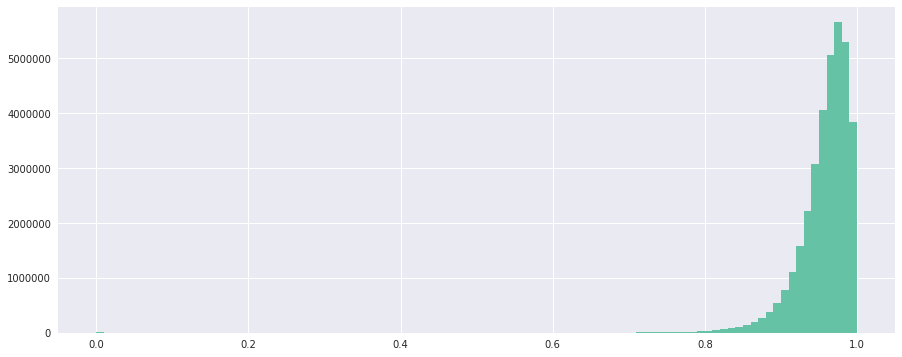

In [13]:
plt.hist(np.nan_to_num(distances, copy=True).flatten(), bins=100);

In [14]:
print('{} distances equal exactly zero.'.format(np.sum(distances == 0)))

5893 distances equal exactly zero.


In [15]:
all_weights = spectral.dist_to_adj_matrix(distances, 'gaussian')

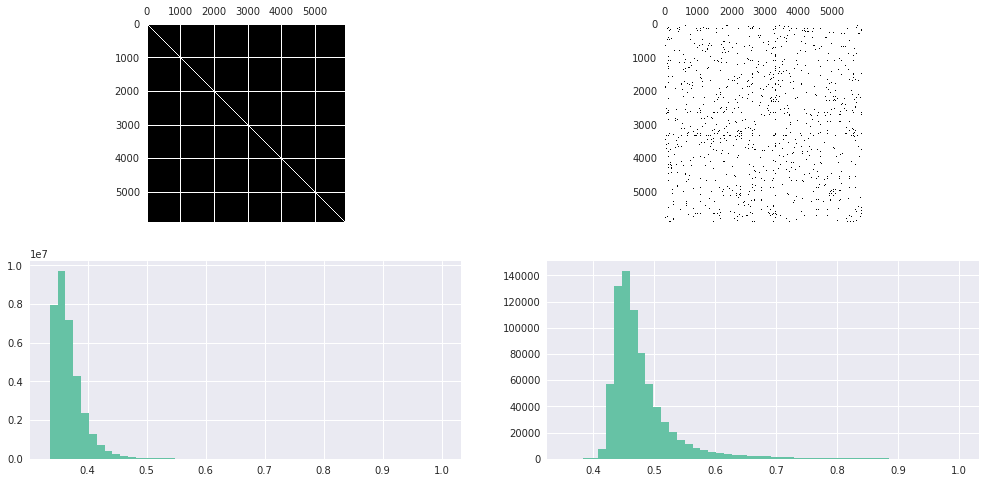

In [16]:
fix, axes = plt.subplots(2, 2, figsize=(17, 8))
def plot(weights, axes):
    axes[0].spy(weights)
    axes[1].hist(weights[weights > 0].reshape(-1), bins=50);

NEIGHBORS = 100
weights = spectral.filter_neighbors(all_weights, NEIGHBORS)

plot(all_weights, axes[:, 0])
plot(weights, axes[:, 1])

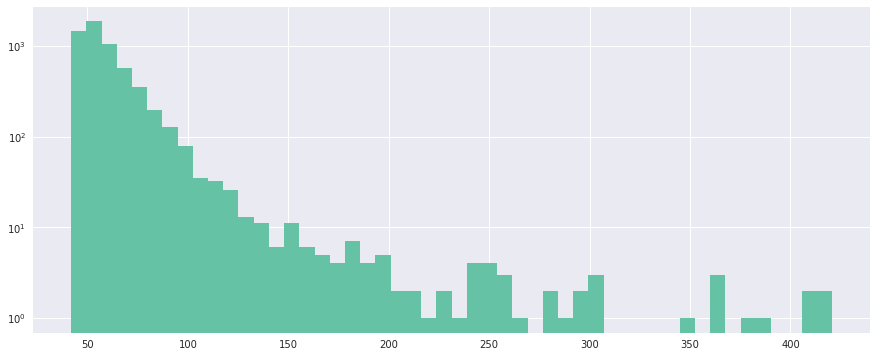

In [17]:
# Weighted degree distribution
degrees = np.sum(weights, axis=0)

plt.hist(degrees, bins=50, log=True);

In [18]:
D = np.diag(degrees)
W = weights
L = D - W

inv_sqrt_D = np.diag(1 / np.diag(D**(0.5)))

normalized_laplacian = inv_sqrt_D @ L @ inv_sqrt_D

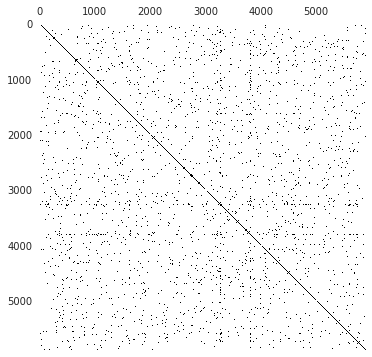

In [19]:
plt.spy(normalized_laplacian);

In [20]:
eigenvalues, eigenvectors = sparse.linalg.eigsh(normalized_laplacian, k=20, which='SM') # which='SA' gives us similar results

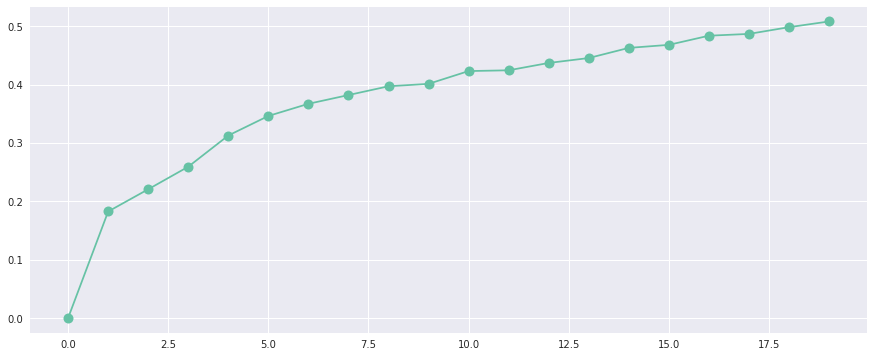

In [21]:
plt.plot(eigenvalues, '.-', markersize=20);

In [22]:
G = nx.from_numpy_matrix(L)
gc = max(nx.connected_component_subgraphs(G), key=len)

In [23]:
assert len(gc.nodes()) == weights.shape[0], "GCC should contain all nodes"

# PCA

In [24]:
features_pca = decomposition.PCA(n_components=3).fit_transform(X)

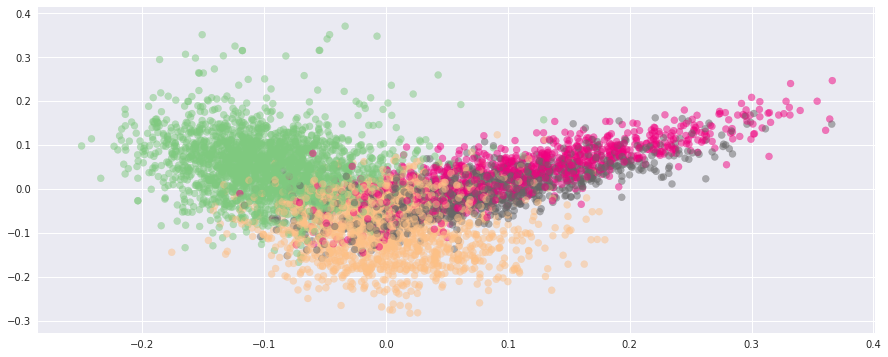

In [25]:
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=y, cmap='Accent', alpha=0.5);

# SPECTRAL

-1394 errors (-23.66%)


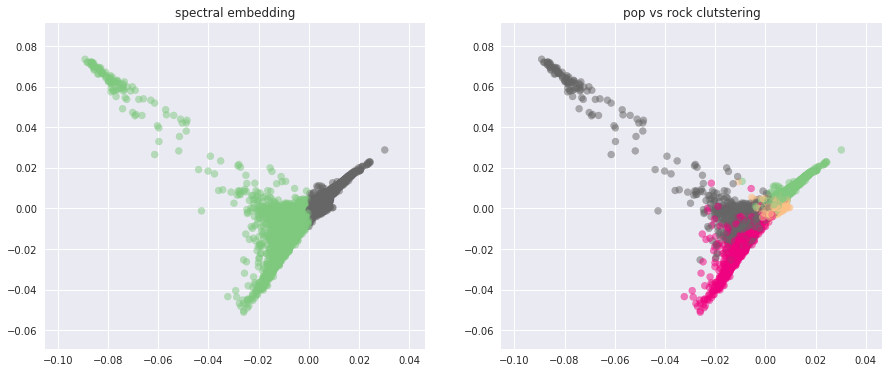

In [26]:
spectral.compare_plot_labels(eigenvectors, y)

# SPECTRAL V2

In [27]:
unsupervised_labels = (eigenvectors[:, 1] - eigenvectors[:, 2]) > 0

In [28]:
accuracy = spectral.compute_err(y, unsupervised_labels)

print('accuracy of {}%'.format(int(accuracy * 10000) / 100))

accuracy of 1.01%


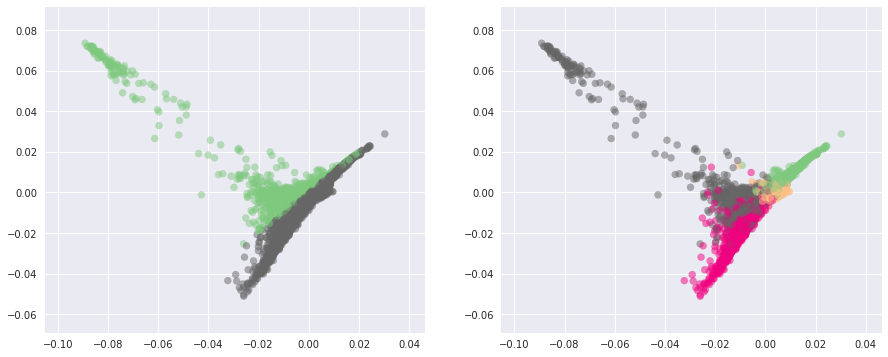

In [29]:
f, axes = plt.subplots(nrows=1, ncols=2)

for ax, lab in zip(axes.flatten(), [unsupervised_labels, y]):
    spectral.plot_labels(eigenvectors, lab, ax=ax)

# 3D

In [30]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

In [31]:
init_notebook_mode(connected=True)
print(__version__)

2.2.3


In [32]:
plots.plot3D(eigenvectors, y, y, parent_cat)

In [33]:
# K Clustering
from sklearn.mixture import GaussianMixture
n_classes = len(set(y))
n_eigen = len(set(y)) 
classifier = GaussianMixture(n_components=n_classes, covariance_type='full', max_iter=500, random_state=42)#max_iter=100)
data = np.array([eigenvectors[:, i] for i in range(n_eigen)]).T

In [35]:
classifier.fit(data)
pred = classifier.predict(data)
predProb = classifier.predict_proba(data)
classifier.predict_proba(data).shape

(5891, 4)

In [36]:
tr_id2name = {0: 'Computer', 1: 'Recreation', 2: 'Religion', 3: 'Politics', 10: 'New point'}
tr_GMMid2label = {}

In [39]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import itertools
def findTranslation(pred, y):
    """Find the best translation possible such that the confusion matrix makes sense (Big value on the diagonal)"""
    maxi = 100000000
    best_tr = []
    for tr in itertools.permutations(range(len(set(y)))):
        lpred = pred.copy()
        for i in range(len(tr)):
            lpred[pred==i] = tr[i]
        cm = confusion_matrix(y_pred=lpred, y_true=y)
        np.fill_diagonal(cm, 0)
        if np.sum(cm) < maxi:
            maxi = np.sum(cm)
            best_tr = tr
    
    return {i:best_tr[i] for i in range(len(best_tr))}
findTranslation(pred, y)

{0: 2, 1: 0, 2: 3, 3: 1}

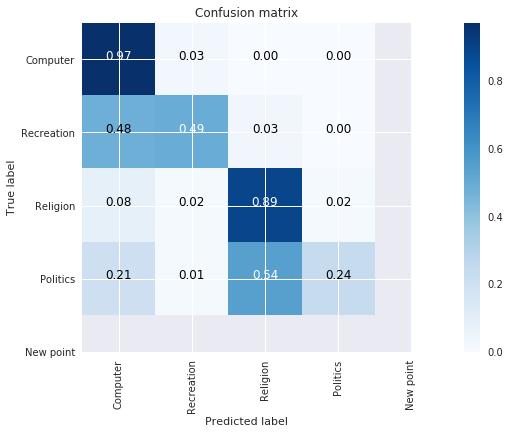

In [45]:
tr_GMMid2label = findTranslation(pred, y)
pred_tr = np.array([tr_GMMid2label[p] for p in pred])
cm = confusion_matrix(y_pred=pred_tr, y_true=y)
plots.plot_confusion_matrix(cm, tr_id2name.values() ,normalize=True)

In [46]:
f1_score(y_pred=pred_tr, y_true=y, average='weighted')

0.64706558161903938

In [48]:
accuracy_score(y_pred=pred_tr, y_true=y)

0.68035987098964523

In [49]:
infos = np.array([plots.dis2text(arr, tr_id2name,tr_GMMid2label) for arr in predProb])
plots.plot3D(eigenvectors, y, infos, tr_id2name)

In [50]:
plots.plot3D(eigenvectors, pred_tr, infos, tr_id2name)